In [1]:
import pandas as pd
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

In [2]:
pd.options.display.float_format = '{:.5f}'.format

In [3]:
plt.style.use('lenk_style')

In [4]:
files = glob.glob('data/*/*.csv')

In [5]:
df_list = []
# cols = ['id', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
#         'instrumentalness', 'liveness', 'valence']
cols = ['id', 'valence']

for f in files:
    df = pd.read_csv(f, usecols=cols)
    df['date'] = pd.to_datetime(re.findall('\d{4}-\d{2}-\d{2}',f)[0])
    df['country_code'] = f.split('/')[1]
    df_list.append(df)

In [6]:
df = pd.concat(df_list, ignore_index=True)

In [7]:
df_c = pd.read_csv('countries.csv')
df = df.merge(df_c, on='country_code', how='left')

In [8]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofweek'] = df['date'].dt.dayofweek

In [9]:
df.head()

,id,valence,date,country_code,country,region,global,day,month,dayofyear,dayofweek
0,2FRnf9qhLbvw8fu4IBXx78,0.94700,2018-12-10,sk,Slovakia,Europe,Global North,10,12,344,0
1,0bYg9bo50gSsH3LtXe2SQn,0.35000,2018-12-10,sk,Slovakia,Europe,Global North,10,12,344,0
2,2VxeLyX666F8uXCJ0dZF8B,0.32300,2018-12-10,sk,Slovakia,Europe,Global North,10,12,344,0
3,2rPE9A1vEgShuZxxzR2tZH,0.43500,2018-12-10,sk,Slovakia,Europe,Global North,10,12,344,0
4,5p7ujcrUXASCNwRaWNHR1C,0.53300,2018-12-10,sk,Slovakia,Europe,Global North,10,12,344,0


In [10]:
df.describe()

,valence,day,month,dayofyear,dayofweek
count,19368568.00000,19368568.00000,19368568.00000,19368568.00000,19368568.00000
mean,0.52479,15.73728,6.34138,177.58200,2.99692
std,0.22125,8.78552,3.36658,102.94372,1.99593
min,0.00000,1.00000,1.00000,1.00000,0.00000
25%,0.35200,8.00000,3.00000,89.00000,1.00000
50%,0.52500,16.00000,6.00000,177.00000,3.00000
75%,0.69700,23.00000,9.00000,262.00000,5.00000
max,0.99900,31.00000,12.00000,366.00000,6.00000


# Distribution

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [12]:
regions = ['Europe', 'South America', 'Asia & Pacific', 'Middle east', 'North America']

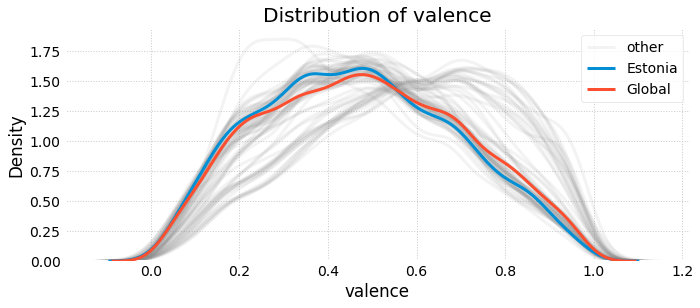

In [13]:
plt.figure(figsize=(10, 4))

for c in df['country'].unique():
    data=df.loc[df['country']==c].groupby('id')[['valence']].mean()
    if c == 'Estonia':
        sns.kdeplot(data=data, x='valence', color=colors[0], zorder=5, label=c)
    elif c == 'Global':
        sns.kdeplot(data=data, x='valence', color=colors[1], zorder=5, label=c)
    elif c == 'United States':
        sns.kdeplot(data=data, x='valence', color=colors[4]+'1A', zorder=1, label='other')
    else:
        sns.kdeplot(data=data, x='valence', color=colors[4]+'1A', zorder=1)

plt.legend()
plt.title('Distribution of valence')
plt.savefig('figs/density.png', dpi=200, bbox_inches='tight')
plt.show()

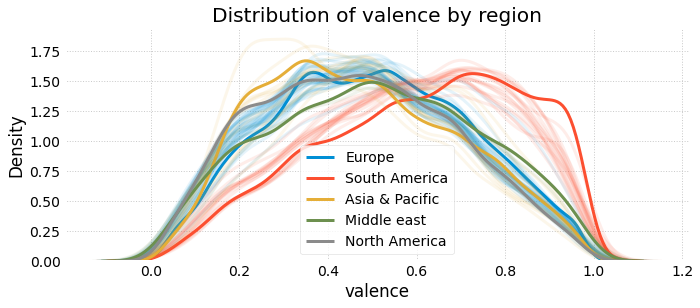

In [14]:
plt.figure(figsize=(10, 4))

for i, r in enumerate(regions):
    sns.kdeplot(data=df.loc[df['region']==r].groupby('id')[['valence']].mean(), 
                x='valence', color=colors[i], label=r)
    for c in df.loc[df['region']==r,'country'].unique():
            sns.kdeplot(data=df.loc[(df['country']==c)&(df['region']==r)].groupby('id')[['valence']].mean(),
                        x='valence', color=colors[i]+'1A')
plt.legend()
plt.title('Distribution of valence by region')
plt.savefig('figs/density-regions.png', dpi=200, bbox_inches='tight')
plt.show()

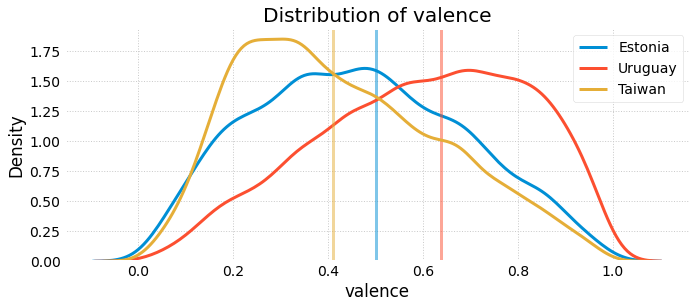

In [15]:
plt.figure(figsize=(10, 4))

for i, c in enumerate(['Estonia', 'Uruguay', 'Taiwan']):
    sns.kdeplot(data=df.loc[df['country']==c].groupby('id')[['valence']].mean(), x='valence', label=c,
                color=colors[i])
    plt.axvline(x=df.loc[df['country']==c]['valence'].mean(), alpha=.5, color=colors[i])

plt.legend()
plt.title('Distribution of valence')
plt.show()

# Seasonality, dynamics

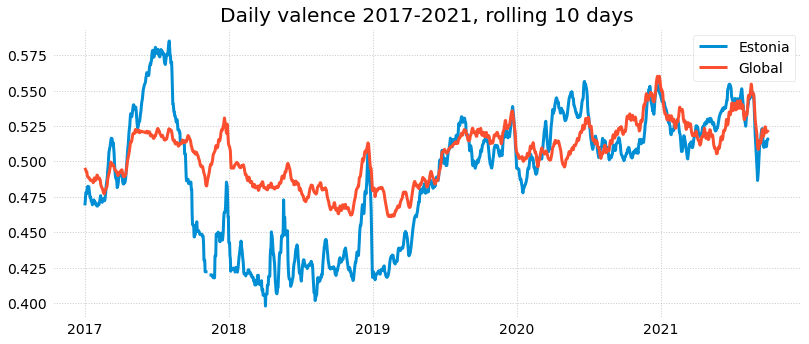

In [16]:
plt.figure(figsize=(12, 5))

data = df.loc[df['country'].isin(['Global','Estonia'])]
data = data.pivot_table(index='date', columns='country',values='valence',aggfunc='mean')

for c in ['Estonia', 'Global']:
    data['valence_rolling'] = data[c].rolling(window=10, min_periods=1, center=True).mean()
    plt.plot(data['valence_rolling'], label=c)

plt.title('Daily valence 2017-2021, rolling 10 days')
plt.legend()
plt.savefig('figs/over-time.png', dpi=200, bbox_inches='tight')
plt.show()

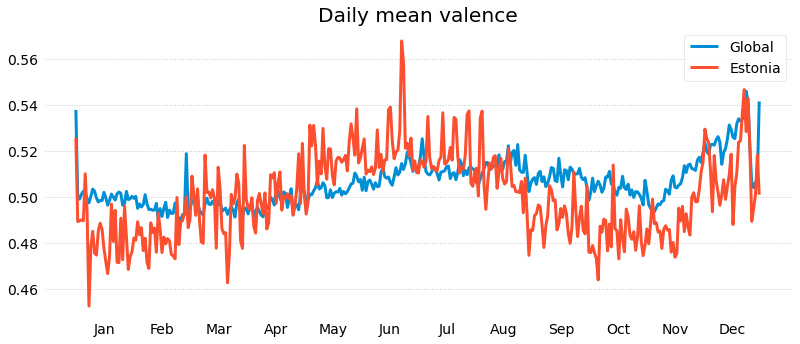

In [17]:
plt.figure(figsize=(12, 5))

for c in ['Global', 'Estonia']:
    data = df[df['country']==c].groupby(['month', 'day'])['valence'].mean().values
    plt.plot(data, label=c)
    
plt.xticks(ticks=np.arange(0, 366, 30.5) + 15.25, labels=[x[:3] for x in calendar.month_name if x])
plt.grid(False, axis='x')
plt.legend()
plt.title('Daily mean valence')
plt.show()

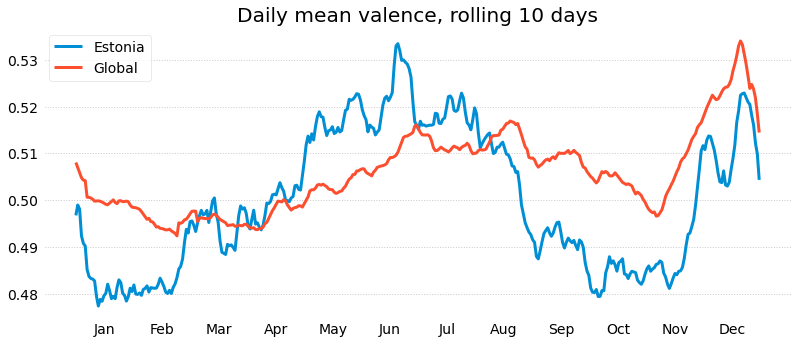

In [18]:
plt.figure(figsize=(12, 5))

for c in ['Estonia', 'Global']:
    df_year = df[df['country']==c].groupby(['month', 'day'], as_index=False)['valence'].mean()
    data = df_year['valence'].rolling(window=10, min_periods=1, center=True).mean()
    plt.plot(data, label=c)
    
# ticks are place in the middle of the month
plt.xticks(ticks=np.arange(0, 366, 30.5) + 15.25, labels=[x[:3] for x in calendar.month_name if x])
plt.grid(False, axis='x')
plt.legend()
plt.title('Daily mean valence, rolling 10 days')
plt.savefig('figs/daily-mean-rolling.png', dpi=200, bbox_inches='tight')
plt.show()

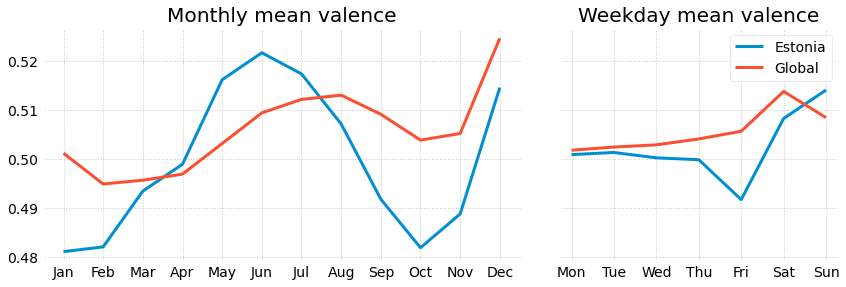

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [12, 7]})
plt.tight_layout()

for c in ['Estonia', 'Global']:
    axes[0].plot(df[df['country']==c].groupby(['month'])['valence'].mean(), label=c)
    axes[1].plot(df[df['country']==c].groupby(['dayofweek'])['valence'].mean(), label=c)

plt.sca(axes[0])
plt.xticks(ticks=np.arange(12)+1, labels=[x[:3] for x in calendar.month_name if x])

plt.sca(axes[1])
plt.xticks(ticks=np.arange(7), labels=[x[:3] for x in calendar.day_name])

axes[0].set_title('Monthly mean valence')
axes[1].set_title('Weekday mean valence')

plt.legend()
plt.savefig('figs/monthly-weekday-mean.png', dpi=200, bbox_inches='tight')
plt.show()

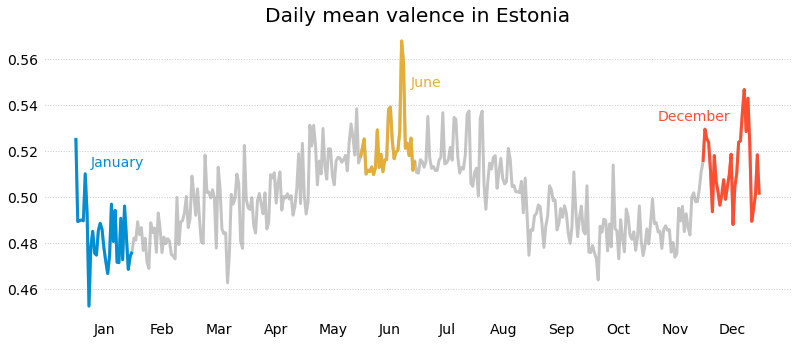

In [20]:
plt.figure(figsize=(12, 5))
data = df[df['country']=='Estonia'].groupby(['month', 'day'], as_index=False)['valence'].mean()

plt.plot(data['valence'], c='#8b8b8b', alpha=.5)
plt.plot(data.loc[data['month']==1,'valence'], c='#008fd5')
plt.plot(data.loc[data['month']==6,'valence'], c='#e5ae38')
plt.plot(data.loc[data['month']==12,'valence'], c='#fc4f30')

plt.annotate('January', (22,.515), va='center', ha='center', color='#008fd5')
plt.annotate('June', (187,.55), va='center', ha='center', color='#e5ae38')
plt.annotate('December', (330,.535), va='center', ha='center', color='#fc4f30')
    
plt.xticks(ticks=np.arange(0, 366, 30.5) + 15.25, labels=[x[:3] for x in calendar.month_name if x])
plt.grid(False, axis='x')
plt.title(f'Daily mean valence in Estonia')
plt.show()

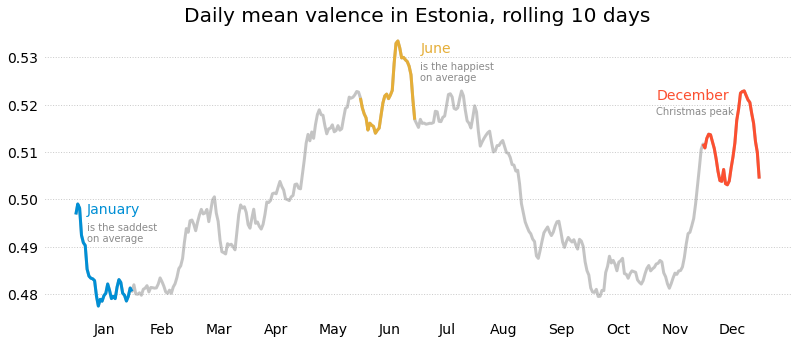

In [21]:
plt.figure(figsize=(12, 5))
df_year = df[df['country']=='Estonia'].groupby(['month', 'day'], as_index=False)['valence'].mean()
data = df_year['valence'].rolling(window=10, min_periods=1, center=True).mean()

plt.plot(data, c='#8b8b8b', alpha=.5)
plt.plot(data[df_year[df_year['month']==1].index], c='#008fd5')
plt.plot(data[df_year[df_year['month']==6].index], c='#e5ae38')
plt.plot(data[df_year[df_year['month']==12].index], c='#fc4f30')

plt.annotate('January', (6,.497), color='#008fd5')
plt.annotate('is the saddest\non average', (6,.491), size=10, color='#8b8b8b')

plt.annotate('June', (184,.531), color='#e5ae38')
plt.annotate('is the happiest\non average', (184,.525), size=10, color='#8b8b8b')

plt.annotate('December', (310,.521), color='#fc4f30')
plt.annotate('Christmas peak', (310,.518), size=10, color='#8b8b8b')
    
plt.xticks(ticks=np.arange(0, 366, 30.5) + 15.25, labels=[x[:3] for x in calendar.month_name if x])
plt.grid(False, axis='x')
plt.title(f'Daily mean valence in Estonia, rolling 10 days')
plt.savefig('figs/daily-mean-rolling-est.png', dpi=200, bbox_inches='tight')
plt.show()

# Average monthly and weekly valence

In [22]:
df.groupby('month')[['valence']].mean().sort_values(by='valence')

,valence
month,
2,0.51540
1,0.51675
3,0.51736
11,0.51976
4,0.52001
10,0.52061
5,0.52553
9,0.52879
12,0.53093


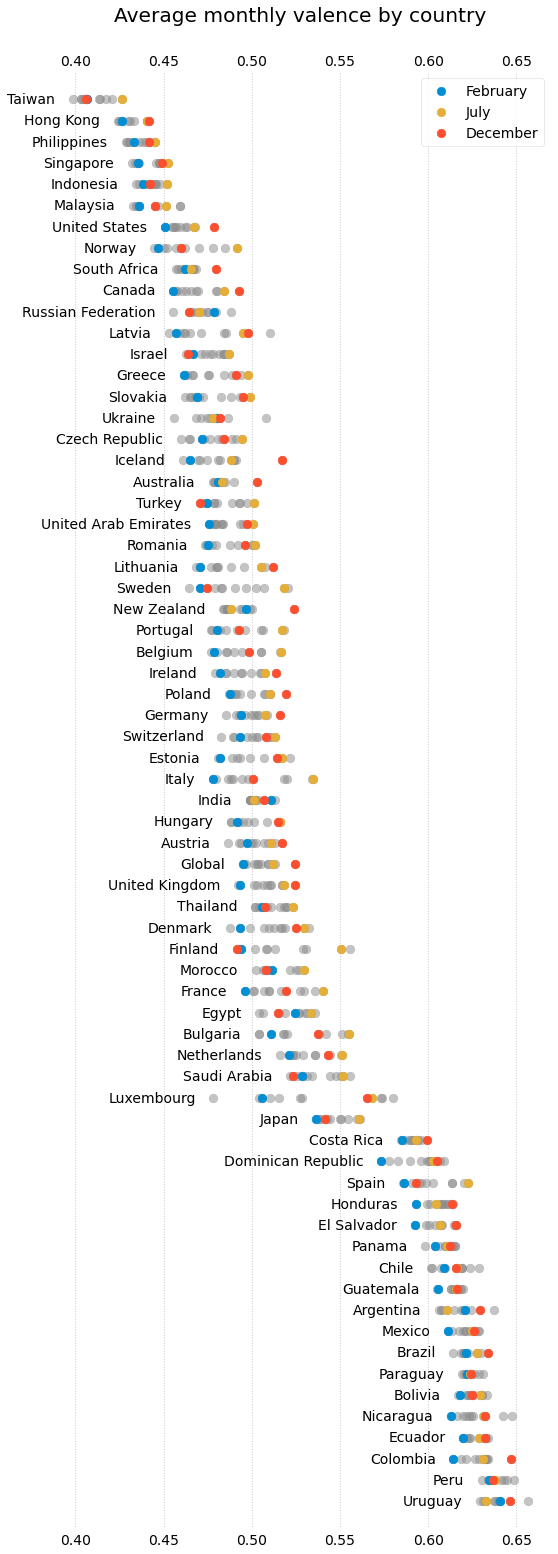

In [23]:
s = 75

# first make sure that all countries have data for all 12 months
countries = df.groupby('country')['month'].nunique()
countries = countries[countries==12].index
# then order the countries by mean valence
countries = df.loc[df['country'].isin(countries)].groupby('country')['valence'].mean().sort_values().index

plt.figure(figsize=(8, 25))
for i, c in enumerate(countries[::-1]):
    data = df.loc[df['country']==c].groupby(['month'])['valence'].mean().to_list()
    plt.scatter(data, [c]*len(data), c='#8b8b8b', alpha=.5, s=s)
    plt.annotate(c, (min(data)-.01, i), va='center', ha='right')
    if c == 'Global':
        plt.scatter(data[1], c, c='#008fd5', s=s, label='February')
        plt.scatter(data[6], c, c='#e5ae38', s=s, label='July')
        plt.scatter(data[11], c, c='#fc4f30', s=s, label='December')
    else:
        plt.scatter(data[1], c, c='#008fd5', s=s)
        plt.scatter(data[6], c, c='#e5ae38', s=s)
        plt.scatter(data[11], c, c='#fc4f30', s=s)

plt.title('Average monthly valence by country', pad=50)

ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.tick_params(top=True, labeltop=True)
plt.margins(y=.02)
plt.legend()
plt.savefig('figs/scatter-month.png', dpi=200, bbox_inches='tight')
plt.show()

In [24]:
df.groupby('dayofweek')[['valence']].mean().sort_values(by='valence')

,valence
dayofweek,
0,0.52194
1,0.52211
2,0.52245
3,0.52372
4,0.52555
6,0.52719
5,0.53058


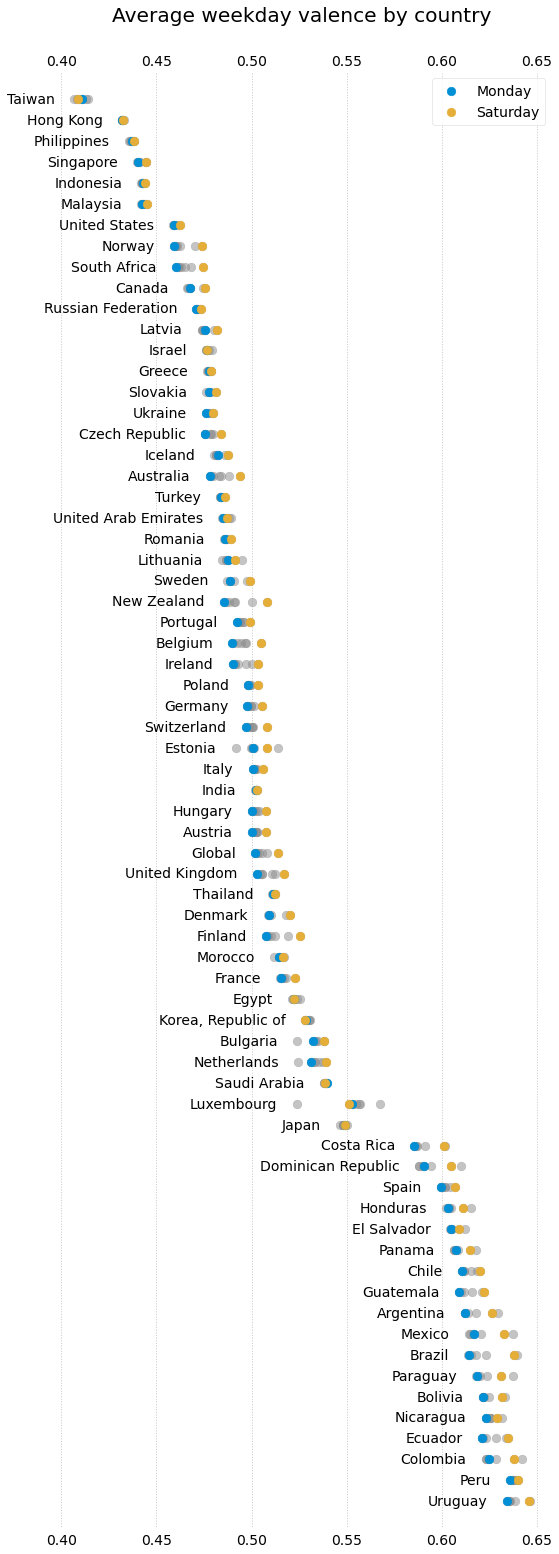

In [25]:
s = 75
countries = df.groupby('country')['valence'].mean().sort_values().index
plt.figure(figsize=(8, 25))

for i, c in enumerate(countries[::-1]):
    data = df.loc[df['country']==c].groupby(['dayofweek'])['valence'].mean().to_list()
    plt.scatter(data, [c]*len(data), c='#8b8b8b', alpha=.5, s=s)
    plt.annotate(c, (min(data)-.01,i), va='center', ha='right')
    if c == 'Global':
        plt.scatter(data[0], c, c='#008fd5', s=s, label='Monday')
        plt.scatter(data[5], c, c='#e5ae38', s=s, label='Saturday')
    else:
        plt.scatter(data[0], c, c='#008fd5', s=s)
        plt.scatter(data[5], c, c='#e5ae38', s=s)
    
plt.title('Average weekday valence by country', pad=50)

ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.tick_params(top=True, labeltop=True)
plt.margins(y=.02)
plt.legend()
plt.savefig('figs/scatter-weekday.png', dpi=200, bbox_inches='tight')
plt.show()